In [49]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import os

In [50]:
# Define the filename and parse parameters
filename = 'gqrx_20251122_160910_1200000000.wav'
base = os.path.basename(filename)
parts = base.split('_')
center_freq_str = parts[-1].split('.')[0]
center_freq = int(center_freq_str)
print(f"Center frequency: {center_freq / 1e6} MHz")

# Load the WAV IQ data (assuming stereo: left real, right imag, int16 or similar)
sample_rate, data = wavfile.read(filename)
print(f"Sample rate: {sample_rate / 1e6} MS/s")
print(f"Loaded data shape: {data.shape}")

if data.ndim != 2 or data.shape[1] != 2:
    raise ValueError("Expected stereo WAV file for IQ data (left: I, right: Q)")

# Convert to complex
iq_data = data[:, 0] + 1j * data[:, 1]

# Normalize based on dtype (assuming signed int16 for full scale)
if data.dtype == np.int16:
    iq_data = iq_data / 32767.0  # Normalize to [-1, 1]
elif data.dtype == np.int32:
    iq_data = iq_data / 2147483647.0
# Add other dtypes if needed

iq_data = iq_data.astype(np.complex64)
print(f"Loaded {len(iq_data)} complex samples")

Center frequency: 1200.0 MHz
Sample rate: 0.048 MS/s
Loaded data shape: (1269984, 2)
Loaded 1269984 complex samples


In [51]:
# Parameters for spectrogram
nperseg = 4096  # FFT length - adjust for resolution (higher = better freq resolution, slower)
noverlap = nperseg // 2  # Overlap for smoother plot

In [52]:
# Compute the spectrogram
f, t, Sxx = signal.spectrogram(iq_data, fs=sample_rate, nperseg=nperseg, noverlap=noverlap, return_onesided=False)

# Shift frequencies to be centered around 0 (baseband)
f = np.fft.fftshift(f)

# Convert to dB for better visualization
Sxx_db = 10 * np.log10(np.fft.fftshift(Sxx, axes=0) + 1e-12)  # Avoid log of zero

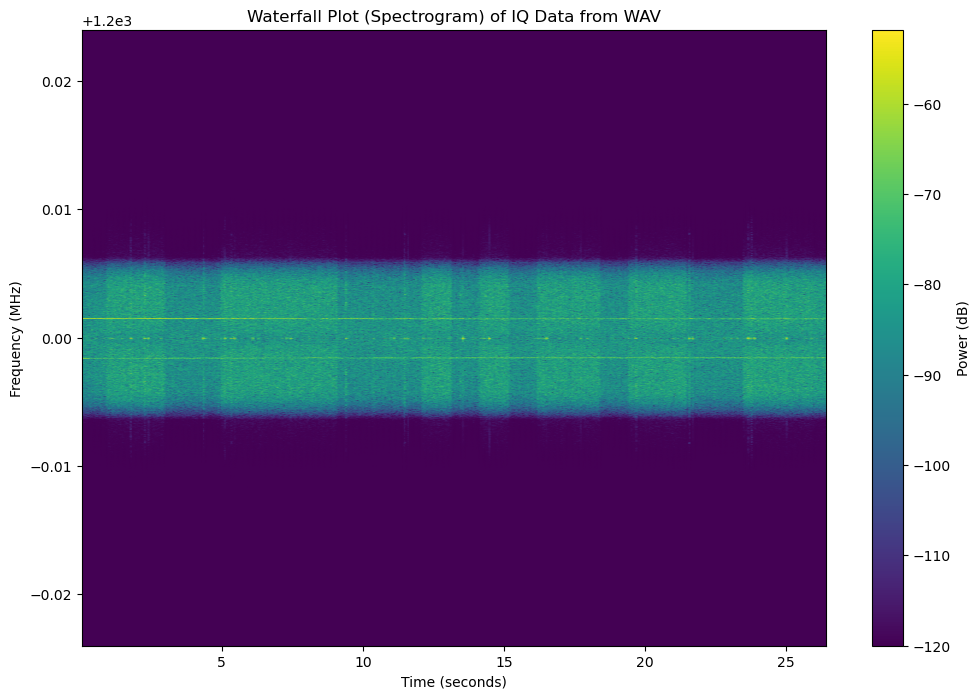

In [53]:
# Plot the waterfall (heatmap) spectrogram
plt.figure(figsize=(12, 8))
plt.pcolormesh(t, (f + center_freq) / 1e6, Sxx_db, shading='gouraud', cmap='viridis')  # Frequencies in MHz
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (seconds)')
plt.title('Waterfall Plot (Spectrogram) of IQ Data from WAV')
plt.colorbar(label='Power (dB)')
plt.show()

In [54]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import os

In [72]:
# Define the filename and parse parameters
filename = 'gqrx_20251122_160910_1200000000.wav'
base = os.path.basename(filename)
parts = base.split('_')
center_freq_str = parts[-1].split('.')[0]
center_freq = int(center_freq_str)
print(f"Center frequency from filename: {center_freq / 1e6} MHz")

# Load the WAV IQ data (assuming stereo: left real, right imag, int16 or similar)
sample_rate, data = wavfile.read(filename)
print(f"Sample rate from WAV header: {sample_rate} kS/s")  # Likely in kHz for audio
print(f"Loaded data shape: {data.shape}")

if data.ndim != 2 or data.shape[1] != 2:
    print("Note: File is not stereo. For mono audio, modify code to use data as real-valued.")
    iq_data = data.astype(np.float32) + 0j  # Treat as real if mono
else:
    # Convert to complex
    iq_data = data[:, 0] + 1j * data[:, 1]

# Normalize based on dtype (assuming signed int16 for full scale)
if data.dtype == np.int16:
    iq_data = iq_data / 32767.0  # Normalize to [-1, 1]
elif data.dtype == np.int32:
    iq_data = iq_data / 2147483647.0
# Add other dtypes if needed

iq_data = iq_data.astype(np.complex64)
print(f"Loaded {len(iq_data)} complex samples")

print(iq_data[1000:1010])

Center frequency from filename: 1200.0 MHz
Sample rate from WAV header: 48000 kS/s
Loaded data shape: (1269984, 2)
Loaded 1269984 complex samples
[0.00396741+0.00396741j 0.00491348+0.00491348j 0.00567644+0.00567644j
 0.00646992+0.00646992j 0.00744652+0.00744652j 0.00866726+0.00866726j
 0.00994903+0.00994903j 0.01110874+0.01110874j 0.01184118+0.01184118j
 0.01193274+0.01193274j]


In [65]:
# Auto-detect if audio or RF IQ based on sample rate
if True:# sample_rate > 1e5:  # Threshold: >100 kS/s likely RF IQ
    is_rf = True
    freq_scale = 1e6
    freq_unit = 'MHz'
    print("Treating as RF IQ data (high sample rate).")
else:
    is_rf = False
    freq_scale = 1e3
    freq_unit = 'kHz'
    print("Treating as audio data (low sample rate).")

# Parameters for spectrogram
nperseg = 1024  # FFT length - adjust for resolution (higher = better freq resolution, slower)
noverlap = nperseg // 2  # Overlap for smoother plot

Treating as RF IQ data (high sample rate).


In [66]:
# Compute the spectrogram
f, t, Sxx = signal.spectrogram(iq_data, fs=sample_rate, nperseg=nperseg, noverlap=noverlap, return_onesided=False)

# Shift frequencies to be centered around 0 (baseband)
f = np.fft.fftshift(f)

# Convert to dB for better visualization
Sxx_db = 10 * np.log10(np.fft.fftshift(Sxx, axes=0) + 1e-12)  # Avoid log of zero

In [67]:
# Adjust frequencies based on type
if is_rf:
    f_plot = f + center_freq
    title = 'Waterfall Plot (Spectrogram) of RF IQ Data from WAV'
else:
    f_plot = f
    title = 'Waterfall Plot (Spectrogram) of Audio Data from WAV'
    # If audio is not IQ, perhaps use real part only
    if data.ndim == 1 or np.allclose(np.imag(iq_data), 0):
        print("Using real part for spectrogram as it appears to be real-valued audio.")
        f, t, Sxx = signal.spectrogram(np.real(iq_data), fs=sample_rate, nperseg=nperseg, noverlap=noverlap, return_onesided=False)
        f = np.fft.fftshift(f)
        Sxx_db = 10 * np.log10(np.fft.fftshift(Sxx, axes=0) + 1e-12)

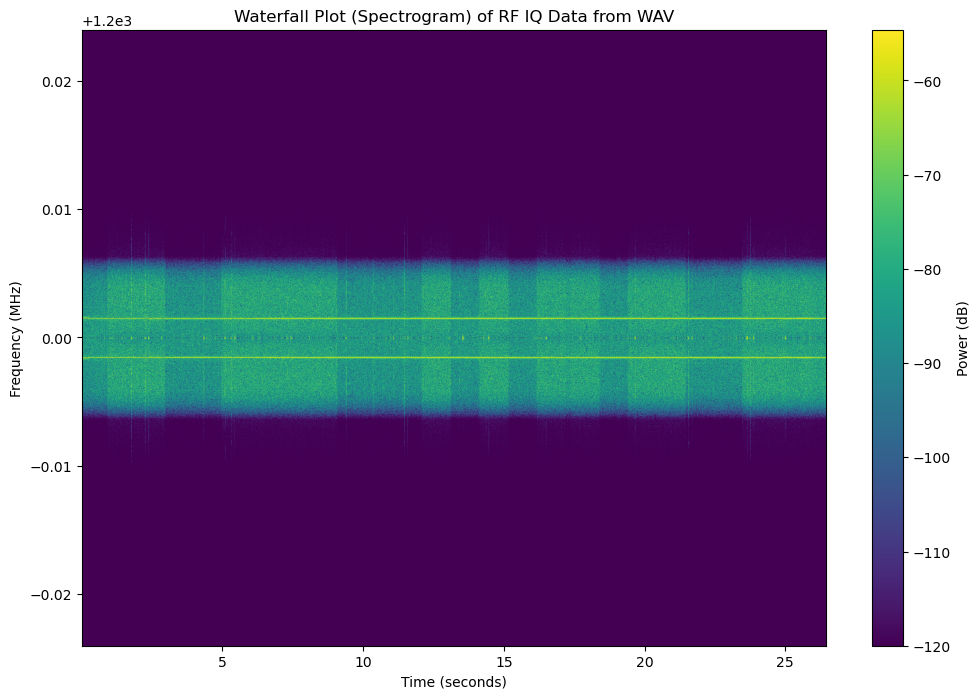

In [68]:
# Plot the waterfall (heatmap) spectrogram
plt.figure(figsize=(12, 8))
plt.pcolormesh(t, f_plot / freq_scale, Sxx_db, shading='gouraud', cmap='viridis')
plt.ylabel(f'Frequency ({freq_unit})')
plt.xlabel('Time (seconds)')
plt.title(title)
plt.colorbar(label='Power (dB)')
plt.show()